Objective: To find the clusters among the customers, such that new customer can be allocated to one of those clusters and 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict

import numpy as np
import pandas as pd
from pathlib import Path


In [ ]:
def loadCsv(path):

  csv_path = Path(path)
  if csv_path.is_file():
    data = pd.read_csv(csv_path, encoding= 'unicode_escape')
  else:
    raise ValueError('Error while reading the csv file.')
  return data

commerce_data = loadCsv('/content/drive/MyDrive/Leapfrog_internship/Major Project/data.csv')

In [ ]:
print('Shape of the data:{}'.format(commerce_data.shape))
commerce_data.head(3)

Shape of the data:(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


Information about the dataset
* Total number of features: 8
* Total number of examples: 541909
* Categorical features: Description, Country
* Nominal features: InvoiceNo, StockCode, Customer ID
* Numeral features: Quantity, UnitPrice
* Date and time feature: Invoice date

Arrtibute Information:

* InvoiceNo: Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* Description: Product (item) name. Nominal.
* Quantity: The quantities of each product (item) per transaction. Numeric.
* InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
* UnitPrice: Unit price. Numeric, Product price per unit in sterling.
* CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* Country: Country name. Nominal, the name of the country where each customer resides.


**Nominal Data** is defined as data that is used for naming or labelling variables, without any quantitative value. It is sometimes called “named” data - a meaning coined from the word nominal.

Here, InvoiceNo, StockCode and Description are nominal data.

In [ ]:
commerce_data.rename(index=str, columns={'InvoiceNo': 'invoice_num',
                              'StockCode' : 'stock_code',
                              'Description' : 'description',
                              'Quantity' : 'quantity',
                              'InvoiceDate' : 'invoice_date',
                              'UnitPrice' : 'unit_price',
                              'CustomerID' : 'customer_id',
                              'Country' : 'country'}, inplace=True)

In [ ]:
def get_attributes_info(data):

  info = defaultdict(list)
  info['Count'], info['dtypes']  = data.count(), data.dtypes.values
  info['Missing_values'] = data.isnull().sum().values
  info['Missing_values (%)'] = info['Missing_values'] / data.shape[0] * 100
  info['Unique'] = data.nunique()
  attributes_info = pd.DataFrame(info)

  return attributes_info

attributes_info = get_attributes_info(commerce_data)
attributes_info

,Count,dtypes,Missing_values,Missing_values (%),Unique
invoice_num,541909,object,0,0.000000,25900
stock_code,541909,object,0,0.000000,4070
description,540455,object,1454,0.268311,4223
quantity,541909,int64,0,0.000000,722
invoice_date,541909,object,0,0.000000,23260
unit_price,541909,float64,0,0.000000,1630
customer_id,406829,float64,135080,24.926694,4372
country,541909,object,0,0.000000,38


######From Missing_values and Missing_values (%):
* Almost 25% of Customer Id's are missing along with 0.27% of Descriptions missing out.
* These missing values add a lot of uncertainities in the analysis, so further looking at them in deep. 


> Analysing the relationship between missing description and customer_id.

In [ ]:
commerce_data[commerce_data.description.isnull()].head(n = 3)

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom


In [ ]:
commerce_data[commerce_data.description.isnull()].tail(n = 3)

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
535332,581209,21620,NaN,6,12/7/2011 18:35,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,12/8/2011 10:33,0.0,NaN,United Kingdom
538554,581408,85175,NaN,20,12/8/2011 14:06,0.0,NaN,United Kingdom


It is observed that the unit_price value is 0.0 for the ones with missing descriptions.
* The null value for price is 0.0, it is not treated as null value because zero actually represents a quantifiable value but as price for any item is cannot be zero, the value should be treated as a missing value so replacing it with NaN.

In [ ]:
commerce_data.unit_price = commerce_data.unit_price.replace({0.0: np.nan})
commerce_data.unit_price.isnull().value_counts()

False    539394
True       2515
Name: unit_price, dtype: int64

In [ ]:
commerce_data[commerce_data.unit_price.isnull()].head(n = 3)

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
622,536414,22139,NaN,56,12/1/2010 11:52,NaN,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,NaN,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,NaN,NaN,United Kingdom


> It looks like whenever the description is missing so is the customer_id and the unit_price.

> **Hypothesis: For missing description of items, both customer_id and unit_price of items are unknown.**

* Numbers of **customer_id** missing for missing **description**.

In [ ]:
commerce_data[commerce_data.description.isnull()].customer_id.isnull().value_counts()

True    1454
Name: customer_id, dtype: int64

* Number of **unit_price** missing for missing **description**.

In [ ]:
commerce_data[commerce_data.description.isnull()].unit_price.isnull().value_counts()

True    1454
Name: unit_price, dtype: int64

Hypothesis verified: For all the values that has missing description also has missing unit_price and customer_id.

Further checking for missing values in any other forms.

In [ ]:
commerce_data.head(n = 3)

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


In [ ]:
commerce_data['description'] = commerce_data.description.str.lower()

nan = commerce_data.description.dropna().apply(
    lambda l: np.where("nan" in l, True, False)
).value_counts()

empty_strings = commerce_data.customer_id.dropna().apply(
    lambda l: np.where("" == l, True, False)
).value_counts()

print('The number of null values present as nan are: {}\n'.format(nan[True]))
print('The number of empty strings present are: \n{}'.format(empty_strings))

The number of null values present as nan are: 731

The number of empty strings present are: 
False    406829
Name: customer_id, dtype: int64


In [ ]:
commerce_data.loc[commerce_data.description.isnull()==False, "description"] = commerce_data.loc[
    commerce_data.description.isnull()==False, "description"
].apply(lambda l: np.where("nan" in l, None, l))

As the unknown are adding too much amount of uncertainity and misinterpretation in the data. Dropping those rows with null values to get correct interpretations for further processing.

In [ ]:
commerce_data.dropna(inplace=True)
commerce_data.isnull().sum().sort_values(ascending=False)

country         0
customer_id     0
unit_price      0
invoice_date    0
quantity        0
description     0
stock_code      0
invoice_num     0
dtype: int64

In [ ]:
commerce_data.describe().round(2)

,quantity,unit_price,customer_id
count,406183.00,406183.00,406183.00
mean,12.03,3.46,15287.66
std,248.11,69.37,1713.66
min,-80995.00,0.00,12346.00
25%,2.00,1.25,13953.00
50%,5.00,1.95,15152.00
75%,12.00,3.75,16791.00
max,80995.00,38970.00,18287.00


* The negative value for quantity is not viable so, it should be removed from the dataset before further processing.


In [ ]:
commerce_data = commerce_data[commerce_data.quantity > 0]
commerce_data.describe().round(2)

,quantity,unit_price,customer_id
count,397287.00,397287.00,397287.00
mean,12.99,3.12,15294.29
std,179.47,22.11,1713.22
min,1.00,0.00,12346.00
25%,2.00,1.25,13969.00
50%,6.00,1.95,15159.00
75%,12.00,3.75,16795.00
max,80995.00,8142.75,18287.00


Conversion of datatypes - 
* InvoiceDate is an object, conversion of it to a datetime datatype for further processing.
* Converting dtype of customer_id from float64 to int64.

In [ ]:
commerce_data.invoice_date = pd.to_datetime(commerce_data.invoice_date)
commerce_data.customer_id = commerce_data.customer_id.astype('int64')

Checking for cancelled invoice numbers  -

In [ ]:
commerce_data['invoice_num'].apply(lambda x:int('C' in x)).value_counts()

0    397287
Name: invoice_num, dtype: int64

In [ ]:
get_attributes_info(commerce_data)

,Count,dtypes,Missing_values,Missing_values (%),Unique
invoice_num,397287,object,0,0.0,18531
stock_code,397287,object,0,0.0,3663
description,397287,object,0,0.0,3875
quantity,397287,int64,0,0.0,301
invoice_date,397287,datetime64[ns],0,0.0,17281
unit_price,397287,float64,0,0.0,440
customer_id,397287,int64,0,0.0,4338
country,397287,object,0,0.0,37


Summary of the tasks till now:
* Changing the features name for simplicity.
* Method to display the count, dtypes, missing values, missing values percentage and unique values in each feature column.
* Removing the rows with the missing (nan, NaN, empty string) values.
* Changing the datatype of invoice_date and customer_id.
* Removing the rows with negative quantity.
* A total of 144622 rows have been removed to eliminate the uncertainities in the data observed until now.
* Verying that there are no further cancelled invoices.

In [ ]:
commerce_data.head(n = 3)

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom


Arranging the columns and removing the order_canceled column.

In [ ]:
commerce_data['spend_amount'] = commerce_data['quantity'] * commerce_data['unit_price']
commerce_data = commerce_data[['invoice_num','invoice_date','stock_code','description','quantity','unit_price', 'spend_amount', 'customer_id','country', ]]
commerce_data.head(n = 3)

,invoice_num,invoice_date,stock_code,description,quantity,unit_price,spend_amount,customer_id,country
0,536365,2010-12-01 08:26:00,85123A,white hanging heart t-light holder,6,2.55,15.30,17850,United Kingdom
1,536365,2010-12-01 08:26:00,71053,white metal lantern,6,3.39,20.34,17850,United Kingdom
2,536365,2010-12-01 08:26:00,84406B,cream cupid hearts coat hanger,8,2.75,22.00,17850,United Kingdom


In [ ]:
import matplotlib.pyplot as plt

**Discovering patterns in invoice_data and number of orders.**

In [ ]:
time_grouping = commerce_data.groupby('invoice_date')[['invoice_num']].count()
time_grouping.columns = ['transactions']
time_grouping.head(n=3)

,transactions
invoice_date,
2010-12-01 08:26:00,7
2010-12-01 08:28:00,2
2010-12-01 08:34:00,16


In [ ]:
time_grouping_daily = time_grouping.resample('D').apply(sum)
time_grouping_daily.head(n=3)

,transactions
invoice_date,
2010-12-01,1942
2010-12-02,2000
2010-12-03,1102


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['font.size'] = 15
# plt.rcParams['lines.linewidth'] = 1.0

def line_plot(agg_posts, title):

  sns.lineplot(data = agg_posts, x = 'invoice_date', y = 'transactions', color='cadetblue')
  plt.title(title)

def bar_plot(agg_posts, title):

  sns.barplot(data = agg_posts, x = 'invoice_date', y = 'transactions',  color='deepskyblue', saturation=0.5)
  plt.title(title)

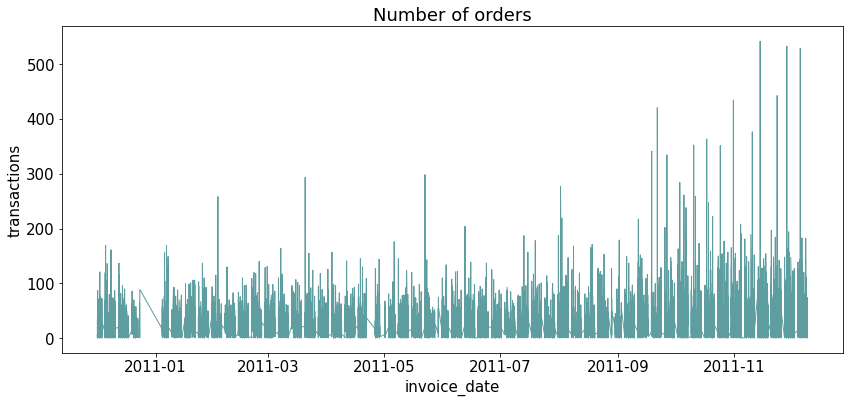

In [ ]:
line_plot(time_grouping, "Number of orders")

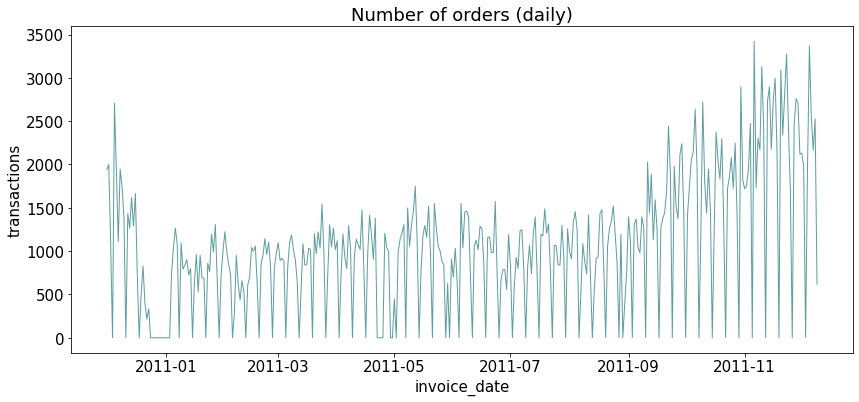

In [ ]:
line_plot(time_grouping_daily, "Number of orders (daily)")

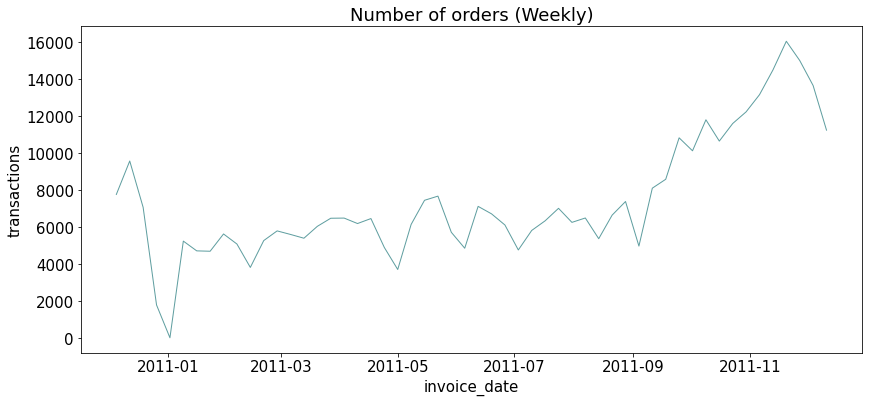

In [ ]:
time_grouping_weekly = time_grouping.resample('W').apply(sum)
line_plot(time_grouping_weekly, "Number of orders (Weekly)")

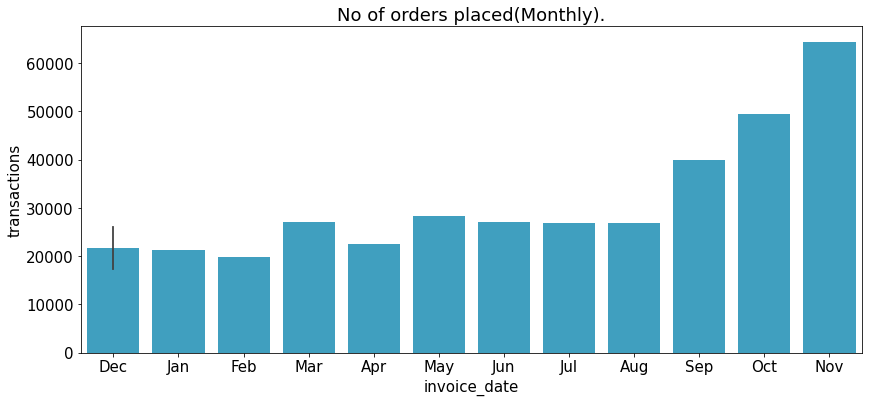

In [ ]:
sns.set_palette("Set3")

def bar_chart(agg_posts, title):
  
  sns.barplot( x = agg_posts['invoice_date'], y = agg_posts['transactions'], color="deepskyblue", saturation=0.5)
  plt.title(title)

def get_publishedDate_df(aggregate_posts):
  aggregate_posts_yearly = aggregate_posts.resample('M').apply(sum)
  date = pd.DataFrame(aggregate_posts_yearly.index)
  date['invoice_date'] = date['invoice_date'].dt.strftime('%b')
  total_aggregate_posts = pd.concat([aggregate_posts_yearly, date.set_index(aggregate_posts_yearly.index)], axis = 1)

  return total_aggregate_posts

total_aggregate_posts = get_publishedDate_df(time_grouping) 
bar_chart(total_aggregate_posts, 'No of orders placed(Monthly).')

In [ ]:
customers_and_transactions = commerce_data.groupby(by=['customer_id'], as_index=False)['invoice_num'].count()
customers_and_transactions.rename(columns={'customer_id': 'customer_id', 'invoice_num': 'no_of_orders'}, inplace = True)

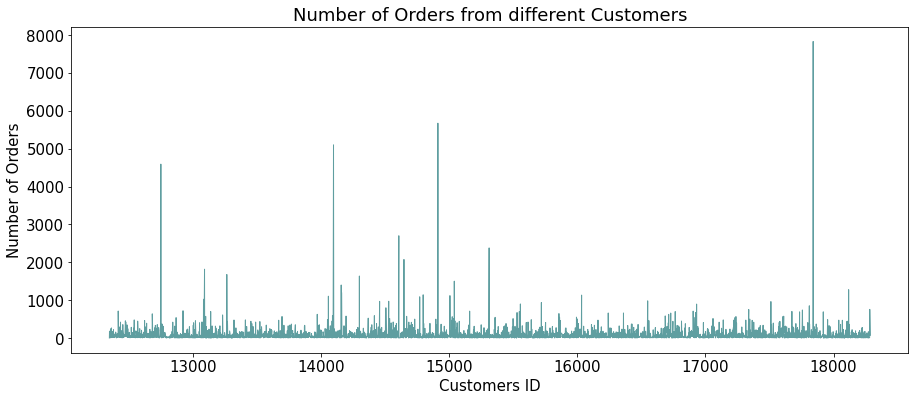

In [ ]:
def visualize_plots(x_axis, y_axis):
    
  plt.subplots(figsize=(15,6))
  plt.plot( x_axis, y_axis, color='cadetblue')
  plt.xlabel('Customers ID')
  plt.ylabel('Number of Orders')
  plt.title('Number of Orders from different Customers')
  plt.show()


visualize_plots(customers_and_transactions.customer_id, customers_and_transactions.no_of_orders)